In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime  
from datetime import timedelta 
import seaborn as sns

# Import user engagement data:

In [2]:
user_engagement_data=pd.read_csv("takehome_user_engagement.csv")

In [3]:
user_data=pd.read_csv("takehome_users.csv", encoding = "ISO-8859-1")

# Data Description:

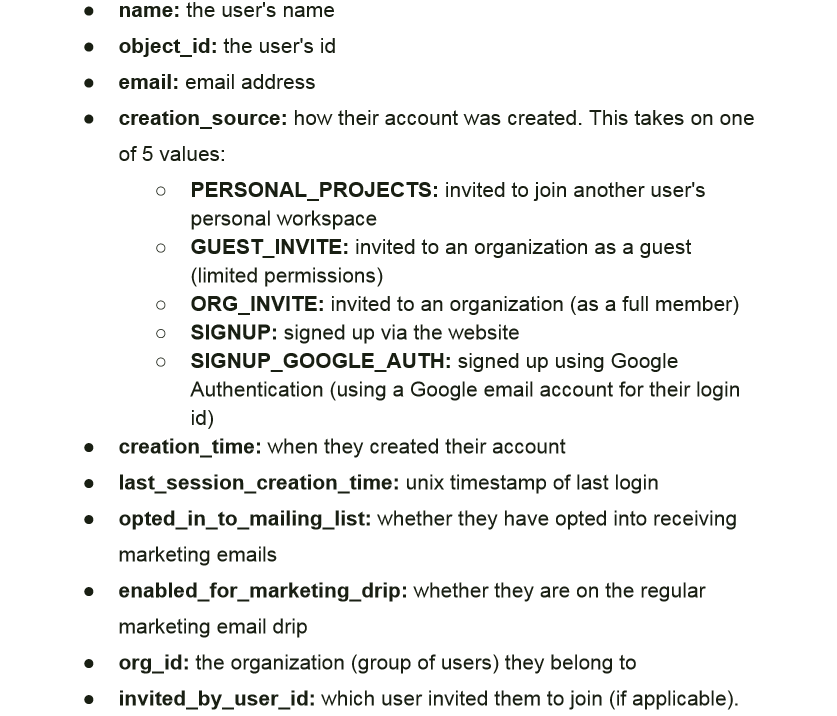

# Here's the definition of the "Adopted User":
Defining   an      "adopted   user"      as   a   user   who         has   logged   into   the   product   on   three   separate  days   in   at   least   one   seven­day   period  ,   identify   which   factors   predict   future   user  adoption  . 


In [4]:
user_data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
user_engagement_data.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


# Identify the adopted user versus the non-adopted user:

In [6]:
def func_return_week_starting_Sunday(date_input1):
    if pd.to_datetime(date_input1).weekday()==6:
        return pd.to_datetime(date_input1)
    if pd.to_datetime(date_input1).weekday()!=6:
        return pd.to_datetime(pd.to_datetime(date_input1)+timedelta(days=7-pd.to_datetime(date_input1).weekday()-8))

In [7]:
user_engagement_data['Week_starting_sunday']=user_engagement_data['time_stamp'].apply(func_return_week_starting_Sunday)

In [8]:
weekly_sessions_by_user=user_engagement_data.groupby(['user_id', 'Week_starting_sunday'])['visited'].sum().reset_index()

In [9]:
max_weekly_sessions_by_user=weekly_sessions_by_user.groupby('user_id')['visited'].max()

In [10]:
Adopted_user_id_list=list(max_weekly_sessions_by_user[max_weekly_sessions_by_user>=3].index)

# Add a user_adoption flag in the user data set and mark the adopted user in the dataset:

In [11]:
user_data['User_adoption_flag']=user_data['object_id'].apply(lambda x: x in Adopted_user_id_list)
user_data['User_adoption_flag']=user_data['User_adoption_flag'].astype(int)

In [12]:
user_data['User_adoption_flag'].unique()

array([0, 1], dtype=int64)

# Create three fields: total login counts in the first 30 days after signing up, Weekly logins (usage frequency), weekly logins (usage frequency) for the first 30 days.

In [13]:
user_data_copy=user_data.copy()

Create a field called "30 days after account creation" within user_data data frame

In [14]:
user_data_copy.creation_time=pd.to_datetime(user_data_copy.creation_time)
user_data_copy['30_days_after_account_creation']=user_data_copy.creation_time + timedelta(days=30)

In [15]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
user_data_copy.to_sql('user_data', con=engine, if_exists='replace')
user_engagement_data.to_sql('user_engagement_data', con=engine, if_exists='replace')

In [16]:
df_30_days_before_account_creation_activity=engine.execute("SELECT b.* FROM user_data a inner join user_engagement_data b on a.creation_time and b.time_stamp <= a.`30_days_after_account_creation` and a.object_id=b.user_id ").fetchall()

In [17]:
df_30_days_before_account_creation_activity=pd.DataFrame(df_30_days_before_account_creation_activity)[[1,2,3,4]]

In [18]:
df_30_days_before_account_creation_activity.columns=['Timestamp', 'user_id', 'Sessions', 'Week']

Get the total number of sessions by user for the first 30 days of account creation:

In [19]:
total_user_sessions_first_30_days=df_30_days_before_account_creation_activity.groupby('user_id')['Sessions'].sum()

Get the average weekly session by user for the first 30 days:

In [20]:
average_weekly_user_sessions_first_30_days=df_30_days_before_account_creation_activity.groupby(['user_id', 'Week'])['Sessions'].sum().reset_index().groupby('user_id')['Sessions'].mean()

Get the average weekly sessions over time:

In [21]:
average_weekly_sessions_over_time=weekly_sessions_by_user.groupby('user_id')['visited'].mean()

Merge the newly created user activity session fields with the user data:

In [22]:
user_data_copy.set_index('object_id', inplace=True)

In [23]:
average_weekly_sessions_over_time=pd.DataFrame(average_weekly_sessions_over_time)
average_weekly_sessions_over_time.columns=['average_weekly_sessions_over_time']

In [24]:
average_weekly_user_sessions_first_30_days=pd.DataFrame(average_weekly_user_sessions_first_30_days) 
average_weekly_user_sessions_first_30_days.columns=['average_weekly_user_sessions_first_30_days']

In [25]:
total_user_sessions_first_30_days=pd.DataFrame(total_user_sessions_first_30_days)
total_user_sessions_first_30_days.columns=['total_user_sessions_first_30_days']

In [26]:
user_data_copy_update=pd.merge(pd.merge(pd.merge(user_data_copy, pd.DataFrame(average_weekly_sessions_over_time), how='left',left_index=True, right_index=True), pd.DataFrame(average_weekly_user_sessions_first_30_days), left_index=True, right_index=True, how='left'), pd.DataFrame(total_user_sessions_first_30_days), left_index=True, right_index=True, how='left')

# Create account day, month, year, day of the week

In [27]:
user_data_copy_update['account_creation_year']=user_data_copy_update.creation_time.dt.year
user_data_copy_update['account_creation_month']=user_data_copy_update.creation_time.dt.month
user_data_copy_update['account_creation_day']=user_data_copy_update.creation_time.dt.day
user_data_copy_update['account_creation_day_of_week']=user_data_copy_update['creation_time'].apply(lambda time: time.dayofweek)

In [28]:
user_data_copy_update.columns

Index(['creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'User_adoption_flag', '30_days_after_account_creation',
       'average_weekly_sessions_over_time',
       'average_weekly_user_sessions_first_30_days',
       'total_user_sessions_first_30_days', 'account_creation_year',
       'account_creation_month', 'account_creation_day',
       'account_creation_day_of_week'],
      dtype='object')

In [29]:
user_data_copy_update.reset_index(inplace=True)

# Create a field called email domain name

In [30]:
user_data_copy_update['email_domain_name']=user_data_copy_update.email.apply(lambda x: x.split('@')[1])

In [31]:
user_data_copy_update['email_domain_name'].unique()

array(['yahoo.com', 'gustr.com', 'jourrapide.com', ..., 'uyhoy.com',
       'eaouk.com', 'iuxiw.com'], dtype=object)

In [32]:
#user_data_copy_update.to_csv("user_data_copy_update.csv", index=False)

In [33]:
user_data_copy_update=pd.read_csv("user_data_copy_update.csv", index_col=False)

In [34]:
def func_domain_name_categorization(domain_name):
    if domain_name in ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']:
        return domain_name
    else:
        return 'other domain'

In [35]:
user_data_copy_update['domain_name_category']=user_data_copy_update['email_domain_name'].apply(func_domain_name_categorization)

In [36]:
user_data_copy_update.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,30_days_after_account_creation,average_weekly_sessions_over_time,average_weekly_user_sessions_first_30_days,total_user_sessions_first_30_days,account_creation_year,account_creation_month,account_creation_day,account_creation_day_of_week,email_domain_name,domain_name_category
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,...,2014-05-22 03:53:30,1.000000,1.0,1.0,2014,4,22,1,yahoo.com,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,...,2013-12-15 03:45:04,1.272727,1.0,3.0,2013,11,15,4,gustr.com,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,...,2013-04-18 23:14:52,1.000000,1.0,1.0,2013,3,19,1,gustr.com,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,...,2013-06-20 08:09:28,1.000000,1.0,1.0,2013,5,21,1,yahoo.com,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,...,2013-02-16 10:14:20,1.000000,1.0,1.0,2013,1,17,3,yahoo.com,yahoo.com


# Create a flag to indicate whether the user and the user who invited him/her is from the same organization

In [37]:
user_data_copy_update1=user_data_copy_update.copy()

In [38]:
user_data_copy_update.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'User_adoption_flag', '30_days_after_account_creation',
       'average_weekly_sessions_over_time',
       'average_weekly_user_sessions_first_30_days',
       'total_user_sessions_first_30_days', 'account_creation_year',
       'account_creation_month', 'account_creation_day',
       'account_creation_day_of_week', 'email_domain_name',
       'domain_name_category'],
      dtype='object')

In [39]:
user_data_copy_update=pd.merge(user_data_copy_update,pd.DataFrame(user_data_copy_update1[['org_id', 'object_id']].rename(columns={'org_id': 'invite_user_org_id'})) , left_on=['invited_by_user_id'], right_on=['object_id'], how='left')

In [40]:
del user_data_copy_update['object_id_y']

In [41]:
user_data_copy_update['invited_by_same_org_flag']=user_data_copy_update['invite_user_org_id']==user_data_copy_update['org_id']

In [42]:
user_data_copy_update['invited_by_same_org_flag'].unique()

array([ True, False])

# Create three fields on the users who got invited:
- Average weekly user sessions for the first 30 days for the user who invited the user
- Total user sessions for the first 30 days for the user who invited the user
- The time difference between the account creation time between the user and the person who invited the user

In [43]:
user_data_copy_update2=user_data_copy_update.copy()

In [44]:
user_data_copy_update2.head()

,object_id_x,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,average_weekly_user_sessions_first_30_days,total_user_sessions_first_30_days,account_creation_year,account_creation_month,account_creation_day,account_creation_day_of_week,email_domain_name,domain_name_category,invite_user_org_id,invited_by_same_org_flag
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,...,1.0,1.0,2014,4,22,1,yahoo.com,yahoo.com,11.0,True
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,...,1.0,3.0,2013,11,15,4,gustr.com,gustr.com,1.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,...,1.0,1.0,2013,3,19,1,gustr.com,gustr.com,94.0,True
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,...,1.0,1.0,2013,5,21,1,yahoo.com,yahoo.com,1.0,True
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,...,1.0,1.0,2013,1,17,3,yahoo.com,yahoo.com,193.0,True


In [45]:
user_data_copy_update.rename(columns={'object_id_x': 'object_id'}, inplace=True)

In [46]:
user_data_copy_update2.rename(columns={'object_id_x': 'object_id'}, inplace=True)

In [47]:
user_data_copy_update2=user_data_copy_update2[['object_id', 'creation_time','average_weekly_user_sessions_first_30_days', 'total_user_sessions_first_30_days' ]]

user_data_copy_update2.columns=['inviter_user_id', 'inviter_creation_time','inviter_average_weekly_user_sessions_first_30_days', 'inviter_total_user_sessions_first_30_days' ]

In [48]:
user_data_copy_update2.columns

Index(['inviter_user_id', 'inviter_creation_time',
       'inviter_average_weekly_user_sessions_first_30_days',
       'inviter_total_user_sessions_first_30_days'],
      dtype='object')

In [49]:
user_data_copy_update3=pd.merge(user_data_copy_update, user_data_copy_update2, left_on=['invited_by_user_id'], right_on=['inviter_user_id'], how='left' )

In [50]:
user_data_copy_update3.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'User_adoption_flag', '30_days_after_account_creation',
       'average_weekly_sessions_over_time',
       'average_weekly_user_sessions_first_30_days',
       'total_user_sessions_first_30_days', 'account_creation_year',
       'account_creation_month', 'account_creation_day',
       'account_creation_day_of_week', 'email_domain_name',
       'domain_name_category', 'invite_user_org_id',
       'invited_by_same_org_flag', 'inviter_user_id', 'inviter_creation_time',
       'inviter_average_weekly_user_sessions_first_30_days',
       'inviter_total_user_sessions_first_30_days'],
      dtype='object')

In [51]:
user_data_copy_update3['creation_time']=pd.to_datetime(user_data_copy_update3['creation_time'])
user_data_copy_update3['inviter_creation_time']=pd.to_datetime(user_data_copy_update3['inviter_creation_time'])

In [52]:
user_data_copy_update3['day_difference_between_accountcreation_user_referer']=user_data_copy_update3['creation_time'] - user_data_copy_update3['inviter_creation_time']

In [53]:
user_data_copy_update3['day_difference_between_accountcreation_user_referer']=user_data_copy_update3['day_difference_between_accountcreation_user_referer'].apply(lambda x: x.days)

# Create a flag to indicate whether the user has someone who refer them or not

In [54]:
user_data_copy_update3.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'User_adoption_flag', '30_days_after_account_creation',
       'average_weekly_sessions_over_time',
       'average_weekly_user_sessions_first_30_days',
       'total_user_sessions_first_30_days', 'account_creation_year',
       'account_creation_month', 'account_creation_day',
       'account_creation_day_of_week', 'email_domain_name',
       'domain_name_category', 'invite_user_org_id',
       'invited_by_same_org_flag', 'inviter_user_id', 'inviter_creation_time',
       'inviter_average_weekly_user_sessions_first_30_days',
       'inviter_total_user_sessions_first_30_days',
       'day_difference_between_accountcreation_user_referer'],
      dtype='object')

In [55]:
user_data_copy_update3['refered_or_not_flag']=0
user_data_copy_update3.loc[pd.isnull(user_data_copy_update3['invited_by_user_id'])==False, 'refered_or_not_flag']=1
user_data_copy_update3.loc[pd.isnull(user_data_copy_update3['invited_by_user_id'])==True, 'refered_or_not_flag']=0

In [56]:
user_data_copy_update3['invited_by_same_org_flag'].unique()

array([ True, False])

In [57]:
user_data_copy_update3.loc[user_data_copy_update3['invited_by_same_org_flag']==True, 'invited_by_same_org_flag']=1
user_data_copy_update3.loc[user_data_copy_update3['invited_by_same_org_flag']==False, 'invited_by_same_org_flag']=0


# Exploratory Analysis on the dataset

# Function for Exploratory Data Analysis:

In [58]:
user_data_copy_update3.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,email_domain_name,domain_name_category,invite_user_org_id,invited_by_same_org_flag,inviter_user_id,inviter_creation_time,inviter_average_weekly_user_sessions_first_30_days,inviter_total_user_sessions_first_30_days,day_difference_between_accountcreation_user_referer,refered_or_not_flag
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,...,yahoo.com,yahoo.com,11.0,1,10803.0,2012-08-09 06:32:29,1.0,1.0,620.0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,...,gustr.com,gustr.com,1.0,1,316.0,2012-08-30 02:58:36,1.0,1.0,442.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,...,gustr.com,gustr.com,94.0,1,1525.0,2012-06-09 23:10:18,1.4,7.0,283.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,...,yahoo.com,yahoo.com,1.0,1,5151.0,2012-06-07 23:34:35,1.0,1.0,347.0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,...,yahoo.com,yahoo.com,193.0,1,5240.0,2012-06-11 08:56:58,1.5,3.0,220.0,1


In [59]:
user_data_copy_update3.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'User_adoption_flag', '30_days_after_account_creation',
       'average_weekly_sessions_over_time',
       'average_weekly_user_sessions_first_30_days',
       'total_user_sessions_first_30_days', 'account_creation_year',
       'account_creation_month', 'account_creation_day',
       'account_creation_day_of_week', 'email_domain_name',
       'domain_name_category', 'invite_user_org_id',
       'invited_by_same_org_flag', 'inviter_user_id', 'inviter_creation_time',
       'inviter_average_weekly_user_sessions_first_30_days',
       'inviter_total_user_sessions_first_30_days',
       'day_difference_between_accountcreation_user_referer',
       'refered_or_not_flag'],
      dtype='object')

In [60]:
def func_variable_exploratory_analysis(dataset, variable_name, variable_type):
    # Make sure variable type is input correctly. If the variable_type input does not fall in the three categories below, an error will be raised.
    if variable_type not in ['Categorical', "Continuous", "Datetime"]:
        raise ValueError("The variable type should be Categorical, Continuous or Datetime")
    else:
        if variable_type=='Categorical':
            print('\033[1m' +"Distribution of the categorical variables:" + variable_name )
            print('\033[0m')
            print(dataset[variable_name].value_counts().sort_index())

            d=dataset[variable_name].value_counts().sort_index()/dataset['object_id'].count()

            print('\033[1m' +"Distribution of the categorical variables (In Percentage):" + variable_name)
            print('\033[0m')
            print(d.apply(lambda x: "{0:.0%}".format(x)))

            print('\033[1m' +"Below is the distribution the of the categorical variable:" + variable_name)
            print('\033[0m')
            
            #dataset[variable_name].hist()
            dataset[variable_name].value_counts().sort_index().plot(kind='bar')
            plt.xlabel(variable_name)
            plt.ylabel("count")
            plt.show()
            
        if variable_type=='Continuous':
            number_of_data_points=dataset[variable_name].count()
            estimate_of_number_bins=int(np.sqrt(number_of_data_points))
            print('\033[1m' +"Descriptive Statistics:" + variable_name)
            print('\033[0m')

            print(dataset[variable_name].describe())


            print('\033[1m' +"Number of observations with missing value for the continuous variable:" + variable_name)
            print('\033[0m')

            print( dataset['object_id'].count()-dataset[variable_name].describe()['count'])


            print('\033[1m' +"PDF and CDF of the variable:" + variable_name)
            print('\033[0m')


            fig=plt.figure()

            ax1=plt.subplot(2,1,1)
            ax1=dataset[variable_name].hist(bins=estimate_of_number_bins)
            plt.title('PDF of the continuous variable')
            plt.ylabel("Distribution")

            ax2=plt.subplot(2,1,2)
            ax2=dataset[variable_name].hist(bins=estimate_of_number_bins, cumulative=True, normed=True)
            plt.title('CDF of the continuous variable')
            plt.xlabel(variable_name)
            plt.ylabel("Distribution")

            ax1.get_shared_x_axes().join(ax1, ax2)
            ax1.set_xticklabels([])
            plt.show()
        if variable_type=='Datetime':
            date_variable=pd.to_datetime(dataset[variable_name])

            print('\033[1m' +"Number of observations with missing value for the continuous variable:" + variable_name)
            print('\033[0m')

            print("Number of observations with missing value for the continuous variable:"+ variable_name, dataset['object_id'].count()-dataset[variable_name].describe()['count'])
            
            print("date range of " + variable_name + " : From " ,date_variable.min(), " To ", date_variable.max() )







Create a list of categorical variables and numerical variables:

In [61]:
user_data_copy_update3.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'User_adoption_flag', '30_days_after_account_creation',
       'average_weekly_sessions_over_time',
       'average_weekly_user_sessions_first_30_days',
       'total_user_sessions_first_30_days', 'account_creation_year',
       'account_creation_month', 'account_creation_day',
       'account_creation_day_of_week', 'email_domain_name',
       'domain_name_category', 'invite_user_org_id',
       'invited_by_same_org_flag', 'inviter_user_id', 'inviter_creation_time',
       'inviter_average_weekly_user_sessions_first_30_days',
       'inviter_total_user_sessions_first_30_days',
       'day_difference_between_accountcreation_user_referer',
       'refered_or_not_flag'],
      dtype='object')

In [62]:
categorical_variables=[ 'domain_name_category', 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip','User_adoption_flag', 'account_creation_month', 'account_creation_day', 'account_creation_day_of_week', 'account_creation_year', 'invited_by_same_org_flag', 'refered_or_not_flag']
continuous_variables=['average_weekly_sessions_over_time','average_weekly_user_sessions_first_30_days', 'total_user_sessions_first_30_days' , 'inviter_average_weekly_user_sessions_first_30_days', 'inviter_total_user_sessions_first_30_days', 'day_difference_between_accountcreation_user_referer'  ]

# Finding on the categorical variables:
- gmail.com and yahoo.com are the email domains used the most.
- Many users created an account through "organization invite".
- Majority of the users did not opt into the mailing list.
- Majority of users did not enable the marketing drip.
- 88% of the users did not adopt the app.
- More users created their accounts during the first half of the year than the second half of the year.
- A lot more users created accounts in 2013 than in 2014 or 2012.
- Around half the users got invited by someone outside of their organization.
- Around half of the users did not get refered by anyone when signing up.

Distribution of the categorical variables:domain_name_category

cuvox.de          1202
gmail.com         3562
gustr.com         1179
hotmail.com       1165
jourrapide.com    1259
other domain      1186
yahoo.com         2447
Name: domain_name_category, dtype: int64
Distribution of the categorical variables (In Percentage):domain_name_category

cuvox.de          10%
gmail.com         30%
gustr.com         10%
hotmail.com       10%
jourrapide.com    10%
other domain      10%
yahoo.com         20%
Name: domain_name_category, dtype: object
Below is the distribution the of the categorical variable:domain_name_category



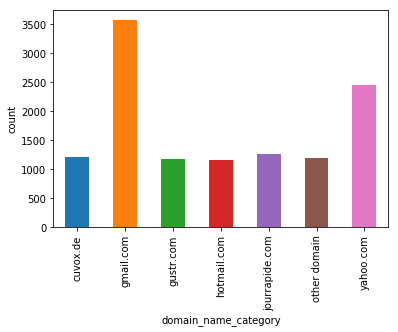

Distribution of the categorical variables:creation_source

GUEST_INVITE          2163
ORG_INVITE            4254
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64
Distribution of the categorical variables (In Percentage):creation_source

GUEST_INVITE          18%
ORG_INVITE            35%
PERSONAL_PROJECTS     18%
SIGNUP                17%
SIGNUP_GOOGLE_AUTH    12%
Name: creation_source, dtype: object
Below is the distribution the of the categorical variable:creation_source



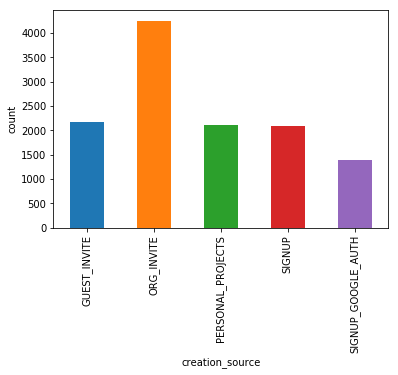

Distribution of the categorical variables:opted_in_to_mailing_list

0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64
Distribution of the categorical variables (In Percentage):opted_in_to_mailing_list

0    75%
1    25%
Name: opted_in_to_mailing_list, dtype: object
Below is the distribution the of the categorical variable:opted_in_to_mailing_list



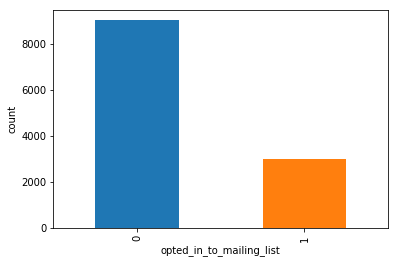

Distribution of the categorical variables:enabled_for_marketing_drip

0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64
Distribution of the categorical variables (In Percentage):enabled_for_marketing_drip

0    85%
1    15%
Name: enabled_for_marketing_drip, dtype: object
Below is the distribution the of the categorical variable:enabled_for_marketing_drip



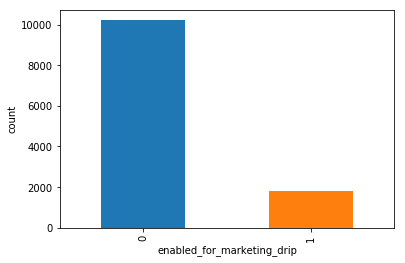

Distribution of the categorical variables:User_adoption_flag

0    10566
1     1434
Name: User_adoption_flag, dtype: int64
Distribution of the categorical variables (In Percentage):User_adoption_flag

0    88%
1    12%
Name: User_adoption_flag, dtype: object
Below is the distribution the of the categorical variable:User_adoption_flag



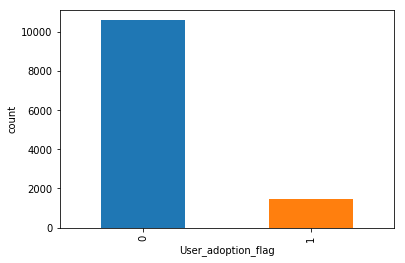

Distribution of the categorical variables:account_creation_month

1     1029
2      934
3     1177
4     1169
5     1455
6      841
7      852
8      852
9      901
10     924
11     936
12     930
Name: account_creation_month, dtype: int64
Distribution of the categorical variables (In Percentage):account_creation_month

1      9%
2      8%
3     10%
4     10%
5     12%
6      7%
7      7%
8      7%
9      8%
10     8%
11     8%
12     8%
Name: account_creation_month, dtype: object
Below is the distribution the of the categorical variable:account_creation_month



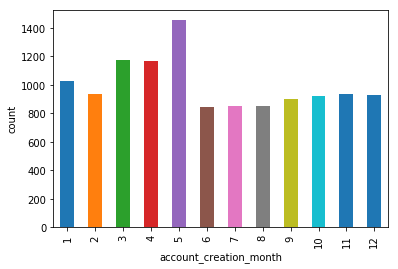

Distribution of the categorical variables:account_creation_day

1     390
2     396
3     402
4     354
5     368
6     377
7     363
8     375
9     368
10    364
11    417
12    365
13    396
14    440
15    385
16    391
17    392
18    423
19    368
20    409
21    406
22    394
23    417
24    398
25    405
26    386
27    422
28    449
29    384
30    392
31    204
Name: account_creation_day, dtype: int64
Distribution of the categorical variables (In Percentage):account_creation_day

1     3%
2     3%
3     3%
4     3%
5     3%
6     3%
7     3%
8     3%
9     3%
10    3%
11    3%
12    3%
13    3%
14    4%
15    3%
16    3%
17    3%
18    4%
19    3%
20    3%
21    3%
22    3%
23    3%
24    3%
25    3%
26    3%
27    4%
28    4%
29    3%
30    3%
31    2%
Name: account_creation_day, dtype: object
Below is the distribution the of the categorical variable:account_creation_day



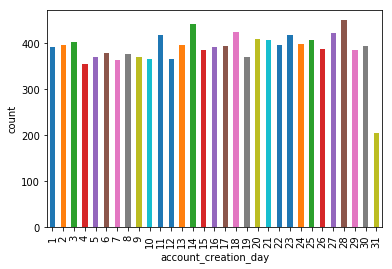

Distribution of the categorical variables:account_creation_day_of_week

0    1712
1    1656
2    1689
3    1803
4    1822
5    1661
6    1657
Name: account_creation_day_of_week, dtype: int64
Distribution of the categorical variables (In Percentage):account_creation_day_of_week

0    14%
1    14%
2    14%
3    15%
4    15%
5    14%
6    14%
Name: account_creation_day_of_week, dtype: object
Below is the distribution the of the categorical variable:account_creation_day_of_week



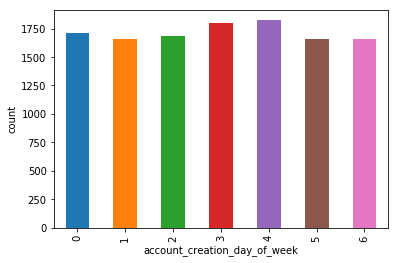

Distribution of the categorical variables:account_creation_year

2012    2797
2013    5676
2014    3527
Name: account_creation_year, dtype: int64
Distribution of the categorical variables (In Percentage):account_creation_year

2012    23%
2013    47%
2014    29%
Name: account_creation_year, dtype: object
Below is the distribution the of the categorical variable:account_creation_year



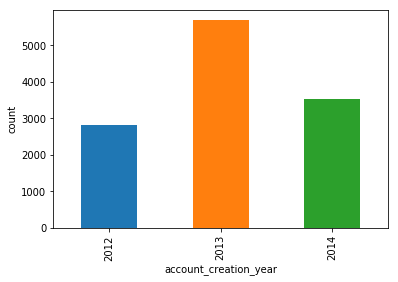

Distribution of the categorical variables:invited_by_same_org_flag

0    5583
1    6417
Name: invited_by_same_org_flag, dtype: int64
Distribution of the categorical variables (In Percentage):invited_by_same_org_flag

0    47%
1    53%
Name: invited_by_same_org_flag, dtype: object
Below is the distribution the of the categorical variable:invited_by_same_org_flag



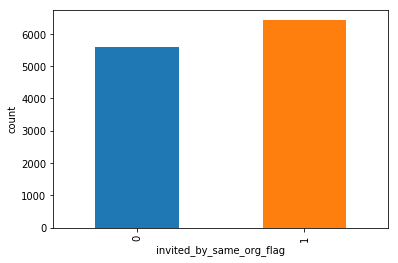

Distribution of the categorical variables:refered_or_not_flag

0    5583
1    6417
Name: refered_or_not_flag, dtype: int64
Distribution of the categorical variables (In Percentage):refered_or_not_flag

0    47%
1    53%
Name: refered_or_not_flag, dtype: object
Below is the distribution the of the categorical variable:refered_or_not_flag



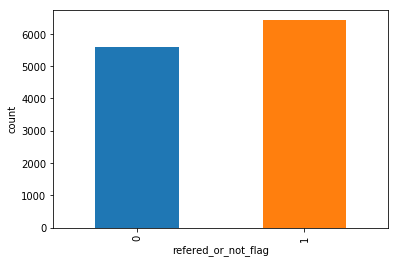

In [63]:
dataset=user_data_copy_update3
variable_type='Categorical'
for variable_name in categorical_variables:
    func_variable_exploratory_analysis(dataset, variable_name, variable_type)

# Below are the findings on the continous variables:
- Majority of the users have up to 1 average weekly sessions over time.
- Majority of users have up to 1 average weekly sessions for the first 30 days.
- Majority of users have up to 2 total sessions for the first 30 days.
- There's not a very strong pattern in terms of the days between user and the inviter

Descriptive Statistics:average_weekly_sessions_over_time

count    8823.00000
mean        1.31332
std         0.80219
min         1.00000
25%         1.00000
50%         1.00000
75%         1.00000
max         6.21978
Name: average_weekly_sessions_over_time, dtype: float64
Number of observations with missing value for the continuous variable:average_weekly_sessions_over_time

3177.0
PDF and CDF of the variable:average_weekly_sessions_over_time



C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


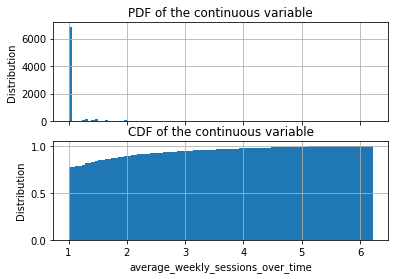

Descriptive Statistics:average_weekly_user_sessions_first_30_days

count    8823.000000
mean        1.068157
std         0.225067
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: average_weekly_user_sessions_first_30_days, dtype: float64
Number of observations with missing value for the continuous variable:average_weekly_user_sessions_first_30_days

3177.0
PDF and CDF of the variable:average_weekly_user_sessions_first_30_days



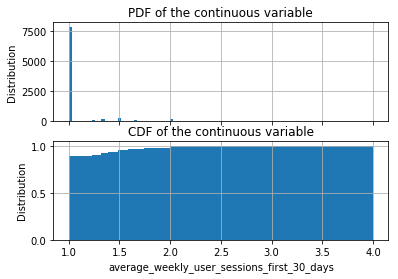

Descriptive Statistics:total_user_sessions_first_30_days

count    8823.000000
mean        1.634251
std         1.441158
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        17.000000
Name: total_user_sessions_first_30_days, dtype: float64
Number of observations with missing value for the continuous variable:total_user_sessions_first_30_days

3177.0
PDF and CDF of the variable:total_user_sessions_first_30_days



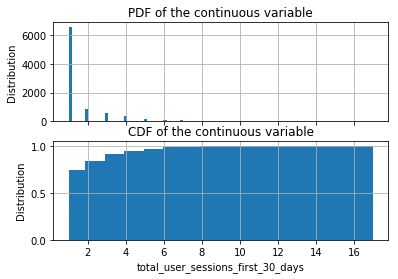

Descriptive Statistics:inviter_average_weekly_user_sessions_first_30_days

count    4724.000000
mean        1.089522
std         0.266862
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: inviter_average_weekly_user_sessions_first_30_days, dtype: float64
Number of observations with missing value for the continuous variable:inviter_average_weekly_user_sessions_first_30_days

7276.0
PDF and CDF of the variable:inviter_average_weekly_user_sessions_first_30_days



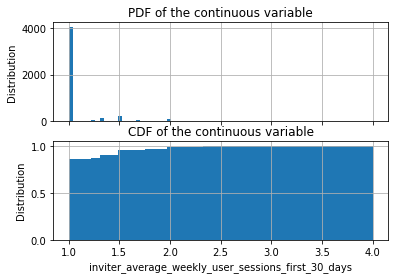

Descriptive Statistics:inviter_total_user_sessions_first_30_days

count    4724.000000
mean        1.774979
std         1.626832
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        17.000000
Name: inviter_total_user_sessions_first_30_days, dtype: float64
Number of observations with missing value for the continuous variable:inviter_total_user_sessions_first_30_days

7276.0
PDF and CDF of the variable:inviter_total_user_sessions_first_30_days



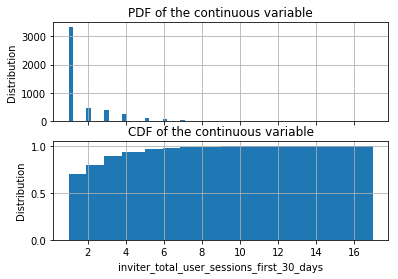

Descriptive Statistics:day_difference_between_accountcreation_user_referer

count    6417.000000
mean      316.464080
std       233.609994
min      -679.000000
25%       126.000000
50%       329.000000
75%       516.000000
max       728.000000
Name: day_difference_between_accountcreation_user_referer, dtype: float64
Number of observations with missing value for the continuous variable:day_difference_between_accountcreation_user_referer

5583.0
PDF and CDF of the variable:day_difference_between_accountcreation_user_referer



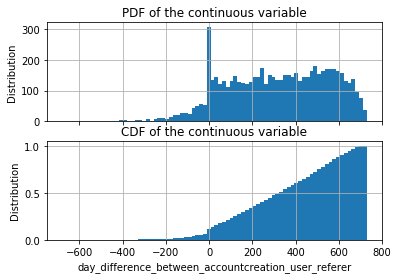

In [64]:
dataset=user_data_copy_update3
variable_type='Continuous'
for variable_name in continuous_variables:
    func_variable_exploratory_analysis(dataset, variable_name, variable_type)

# Explore the importance on the categorical variables to the user adoption flag:

# Below are the findings: 
- Users who did not opt the mailing list are less likely to be adopted users.
- Users who did not enable the marketing drip are less likely to be adopted users.
- Users who created their account in March, April and May are less likely to be adopted users.
- Even though there are a lot more users who created account in 2013, the proportion of the user who are not adopted is also high.


In [66]:
def func_exploratory_analysis_categorical_variable(dataset, variable_name):
    df_plot=pd.DataFrame()
    df_plot=dataset.groupby(['User_adoption_flag', variable_name ])['object_id'].count().reset_index()
    fig, ax = plt.subplots(figsize=(15,5))
    ax = sns.barplot(x=variable_name, y="object_id", hue="User_adoption_flag", data=df_plot)
    ax.set_xlabel(variable_name)
    ax.set_ylabel("Number of users")
    ax.set_title("Number of Users By " + variable_name + ' between adopted users and non-adopted users')
    plt.show()


In [67]:
categorical_variables1=['domain_name_category',
 'creation_source',
 'opted_in_to_mailing_list',
 'enabled_for_marketing_drip',
 'account_creation_month',
 'account_creation_day',
 'account_creation_day_of_week',
 'account_creation_year',
 'invited_by_same_org_flag',
 'refered_or_not_flag']

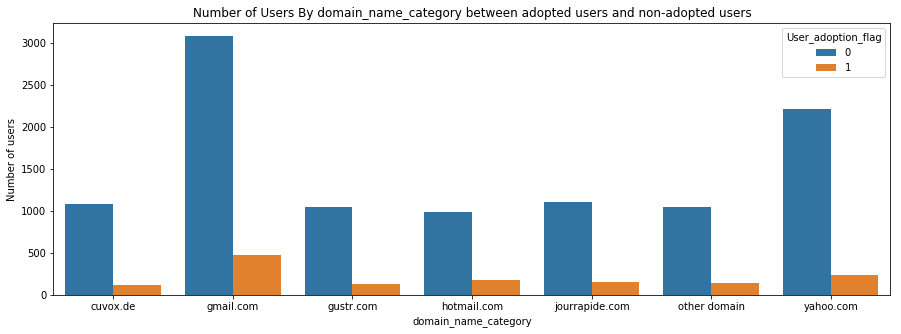

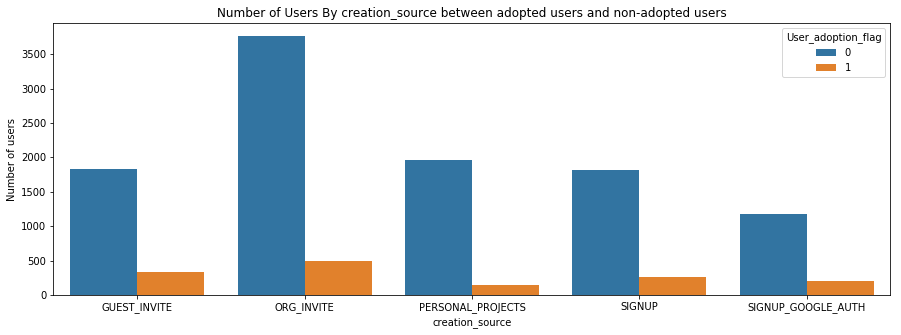

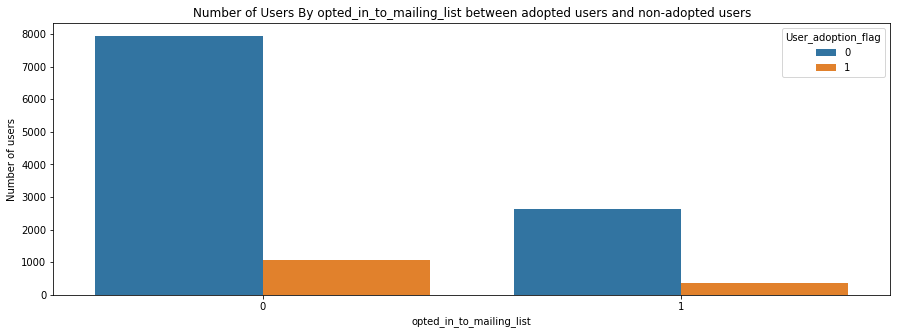

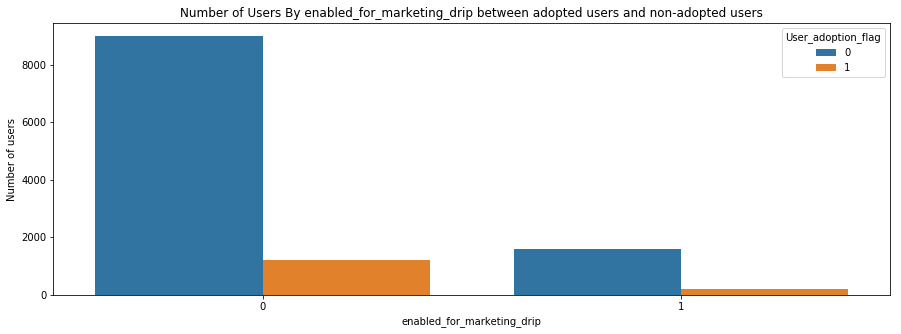

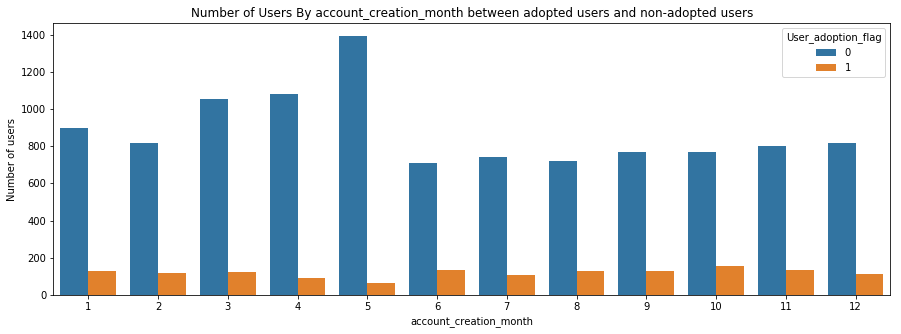

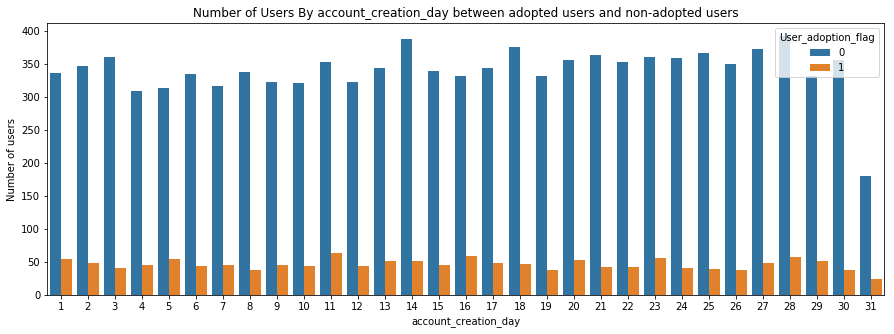

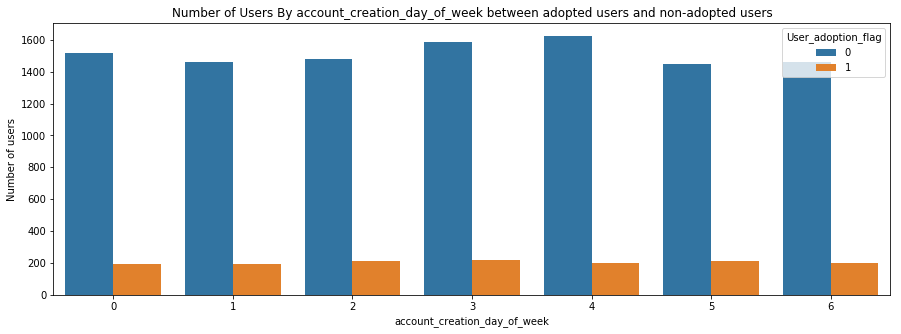

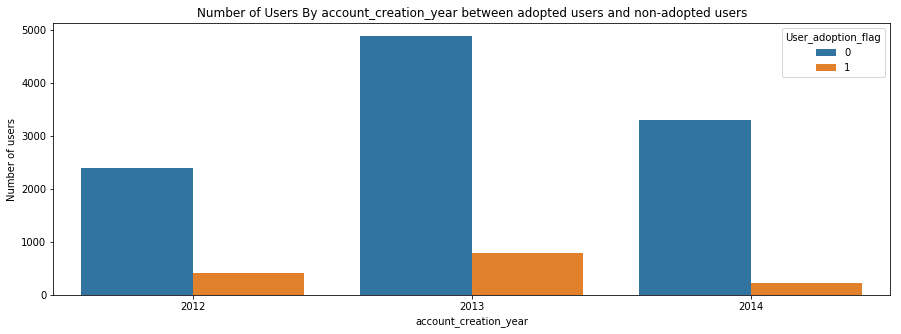

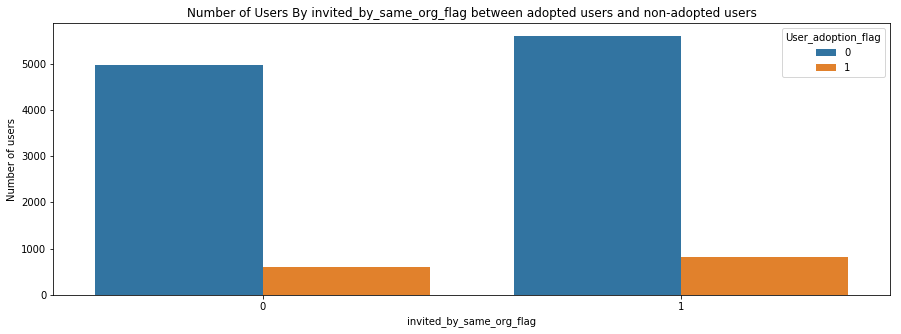

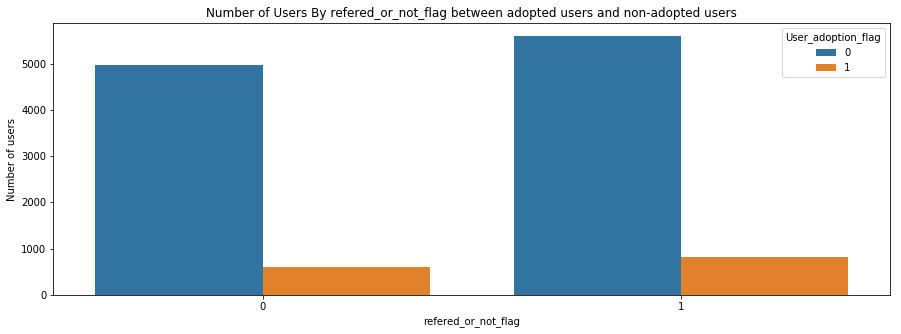

In [68]:
dataset=user_data_copy_update3
for variable in categorical_variables1:
    func_exploratory_analysis_categorical_variable(dataset, variable)
    

In [69]:
import warnings

In [70]:
def func_exploratory_analysis_continuous_variable(dataset, variable):
    warnings.simplefilter('ignore')
    print("Below is the distribution of variable ", variable, ":", "\n")
    print(dataset.groupby('User_adoption_flag')[variable].mean())

    sns.boxplot(x='User_adoption_flag', y=variable,
                hue='User_adoption_flag',
                data=dataset)
    plt.show()
    
    print("Below is the histogram of the "+ variable + " :")
    sns.distplot(dataset[variable], bins=int(np.sqrt(dataset.shape[0])))
    plt.show()


# Below is the finding on the correlation between the continuous variables and user adoption flag:
- Adopted users have higher average weekly sessions over time on average.
- Adopted users have higher average weekly sessions for the first 30 days on average.
- Adopted users have higher total sessions for the first 30 days.


Below is the distribution of variable  average_weekly_sessions_over_time : 

User_adoption_flag
0    1.029898
1    2.773714
Name: average_weekly_sessions_over_time, dtype: float64


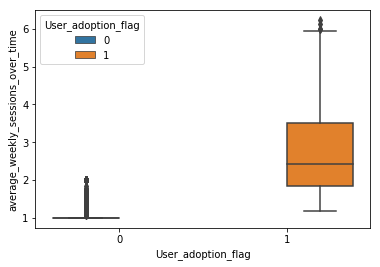

Below is the histogram of the average_weekly_sessions_over_time :


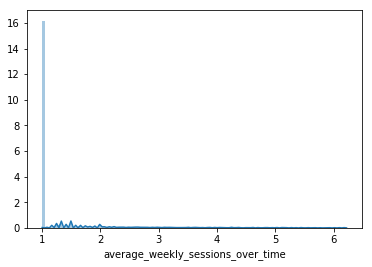

Below is the distribution of variable  average_weekly_user_sessions_first_30_days : 

User_adoption_flag
0    1.026792
1    1.281299
Name: average_weekly_user_sessions_first_30_days, dtype: float64


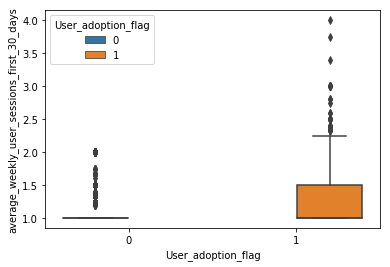

Below is the histogram of the average_weekly_user_sessions_first_30_days :


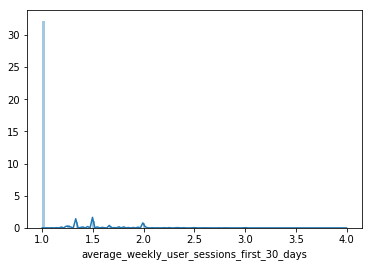

Below is the distribution of variable  total_user_sessions_first_30_days : 

User_adoption_flag
0    1.272161
1    3.500000
Name: total_user_sessions_first_30_days, dtype: float64


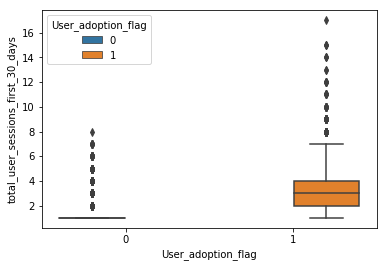

Below is the histogram of the total_user_sessions_first_30_days :


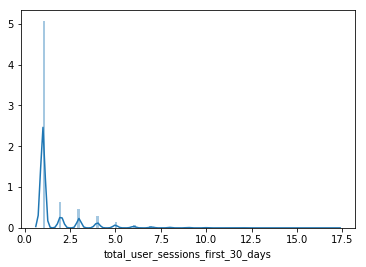

Below is the distribution of variable  inviter_average_weekly_user_sessions_first_30_days : 

User_adoption_flag
0    1.086098
1    1.111973
Name: inviter_average_weekly_user_sessions_first_30_days, dtype: float64


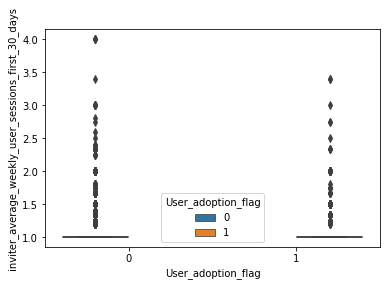

Below is the histogram of the inviter_average_weekly_user_sessions_first_30_days :


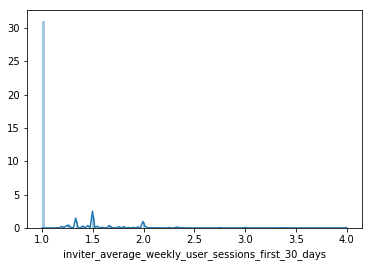

Below is the distribution of variable  inviter_total_user_sessions_first_30_days : 

User_adoption_flag
0    1.743108
1    1.984000
Name: inviter_total_user_sessions_first_30_days, dtype: float64


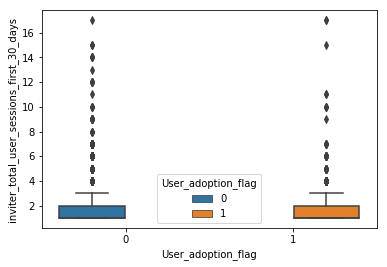

Below is the histogram of the inviter_total_user_sessions_first_30_days :


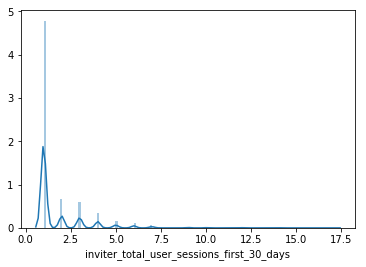

Below is the distribution of variable  day_difference_between_accountcreation_user_referer : 

User_adoption_flag
0    325.309864
1    256.170524
Name: day_difference_between_accountcreation_user_referer, dtype: float64


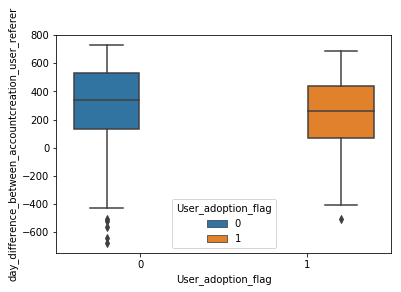

Below is the histogram of the day_difference_between_accountcreation_user_referer :


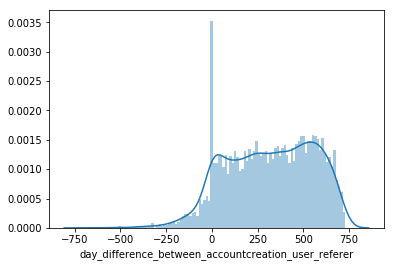

In [71]:
dataset=user_data_copy_update3
for variable in continuous_variables:
    func_exploratory_analysis_continuous_variable(dataset, variable)

# Below are variables that I'm going to include for the classification model:

In [72]:
user_data_copy_update3.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'User_adoption_flag', '30_days_after_account_creation',
       'average_weekly_sessions_over_time',
       'average_weekly_user_sessions_first_30_days',
       'total_user_sessions_first_30_days', 'account_creation_year',
       'account_creation_month', 'account_creation_day',
       'account_creation_day_of_week', 'email_domain_name',
       'domain_name_category', 'invite_user_org_id',
       'invited_by_same_org_flag', 'inviter_user_id', 'inviter_creation_time',
       'inviter_average_weekly_user_sessions_first_30_days',
       'inviter_total_user_sessions_first_30_days',
       'day_difference_between_accountcreation_user_referer',
       'refered_or_not_flag'],
      dtype='object')

In [73]:
categorical_variables_to_use=['opted_in_to_mailing_list', 'creation_source', 'enabled_for_marketing_drip', 'invited_by_same_org_flag','domain_name_category','account_creation_year', 'account_creation_month', 'account_creation_day', 'account_creation_day_of_week' ]
continuous_variables_to_use=['average_weekly_user_sessions_first_30_days', 'total_user_sessions_first_30_days',  'inviter_average_weekly_user_sessions_first_30_days','inviter_total_user_sessions_first_30_days']
label='User_adoption_flag'

In [74]:
categorical_variables_to_use=['opted_in_to_mailing_list', 'creation_source', 'enabled_for_marketing_drip', 'invited_by_same_org_flag','domain_name_category','account_creation_year', 'account_creation_month', 'account_creation_day', 'account_creation_day_of_week' ]
continuous_variables_to_use=['average_weekly_user_sessions_first_30_days', 'total_user_sessions_first_30_days',  'inviter_average_weekly_user_sessions_first_30_days','inviter_total_user_sessions_first_30_days']
label='User_adoption_flag'

In [75]:
variables_to_use=['object_id','User_adoption_flag','opted_in_to_mailing_list', 'creation_source', 'enabled_for_marketing_drip', 'invited_by_same_org_flag','domain_name_category','account_creation_year', 'account_creation_month', 'account_creation_day', 'account_creation_day_of_week', 'average_weekly_user_sessions_first_30_days', 'total_user_sessions_first_30_days',  'inviter_average_weekly_user_sessions_first_30_days','inviter_total_user_sessions_first_30_days' ]

In [76]:
user_data_copy_update4=user_data_copy_update3[variables_to_use]

# Use one-hot encoding to create dummy variables for the variables below:

In [77]:
create_dummy_variables_list=['creation_source', 'domain_name_category', 'account_creation_year', 'account_creation_month', 'account_creation_day', 'account_creation_day_of_week']

In [78]:
for variable in create_dummy_variables_list:
    dummy_variables=pd.get_dummies(user_data_copy_update4[variable])
    dummy_variables.columns=[variable + "_" + str(x) for x in dummy_variables.columns]
    dummy_variables=dummy_variables.iloc[:,1:]
    del user_data_copy_update4[variable]
    user_data_copy_update4=pd.merge(user_data_copy_update4, dummy_variables, left_index=True, right_index=True)
    

# Below are the columns that will be included in the model:

In [79]:
user_data_copy_update4.columns

Index(['object_id', 'User_adoption_flag', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'invited_by_same_org_flag',
       'average_weekly_user_sessions_first_30_days',
       'total_user_sessions_first_30_days',
       'inviter_average_weekly_user_sessions_first_30_days',
       'inviter_total_user_sessions_first_30_days',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH',
       'domain_name_category_gmail.com', 'domain_name_category_gustr.com',
       'domain_name_category_hotmail.com',
       'domain_name_category_jourrapide.com',
       'domain_name_category_other domain', 'domain_name_category_yahoo.com',
       'account_creation_year_2013', 'account_creation_year_2014',
       'account_creation_month_2', 'account_creation_month_3',
       'account_creation_month_4', 'account_creation_month_5',
       'account_creation_month_6', 'account_creation_month_7',
       'acco

In [80]:
user_data_copy_update4.describe()

,object_id,User_adoption_flag,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_same_org_flag,average_weekly_user_sessions_first_30_days,total_user_sessions_first_30_days,inviter_average_weekly_user_sessions_first_30_days,inviter_total_user_sessions_first_30_days,creation_source_ORG_INVITE,...,account_creation_day_28,account_creation_day_29,account_creation_day_30,account_creation_day_31,account_creation_day_of_week_1,account_creation_day_of_week_2,account_creation_day_of_week_3,account_creation_day_of_week_4,account_creation_day_of_week_5,account_creation_day_of_week_6
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,8823.000000,8823.000000,4724.000000,4724.000000,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,0.119500,0.249500,0.149333,0.534750,1.068157,1.634251,1.089522,1.774979,0.354500,...,0.037417,0.032000,0.032667,0.017000,0.138000,0.140750,0.150250,0.151833,0.138417,0.138083
std,3464.24595,0.324389,0.432742,0.356432,0.498812,0.225067,1.441158,0.266862,1.626832,0.478381,...,0.189788,0.176007,0.177770,0.129276,0.344914,0.347778,0.357331,0.358874,0.345351,0.345002
min,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3000.75000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6000.50000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9000.25000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12000.00000,1.000000,1.000000,1.000000,1.000000,4.000000,17.000000,4.000000,17.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Check if there's any missing data in the user_data_copy_update4 data frame:

In [81]:
for column in user_data_copy_update4.columns:
    if user_data_copy_update4[column].count()!=12000:
        print(column)
    

average_weekly_user_sessions_first_30_days
total_user_sessions_first_30_days
inviter_average_weekly_user_sessions_first_30_days
inviter_total_user_sessions_first_30_days


In [82]:
user_data_copy_update4.set_index('object_id', inplace=True)

For the fields with missing data above, I'm going to replace the missing value with 0 since the missing information means that there's no acitivity.

In [83]:
for variable in ['average_weekly_user_sessions_first_30_days',
'total_user_sessions_first_30_days',
'inviter_average_weekly_user_sessions_first_30_days',
'inviter_total_user_sessions_first_30_days']:
    user_data_copy_update4[variable]=user_data_copy_update4[variable].fillna(0)
    

In [84]:
for column in user_data_copy_update4.columns:
    user_data_copy_update4[column]=user_data_copy_update4[column].astype('float')

In [85]:
user_data_copy_update4.describe()

,User_adoption_flag,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_same_org_flag,average_weekly_user_sessions_first_30_days,total_user_sessions_first_30_days,inviter_average_weekly_user_sessions_first_30_days,inviter_total_user_sessions_first_30_days,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,...,account_creation_day_28,account_creation_day_29,account_creation_day_30,account_creation_day_31,account_creation_day_of_week_1,account_creation_day_of_week_2,account_creation_day_of_week_3,account_creation_day_of_week_4,account_creation_day_of_week_5,account_creation_day_of_week_6
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.119500,0.249500,0.149333,0.534750,0.785362,1.201583,0.428908,0.698750,0.354500,0.175917,...,0.037417,0.032000,0.032667,0.017000,0.138000,0.140750,0.150250,0.151833,0.138417,0.138083
std,0.324389,0.432742,0.356432,0.498812,0.509272,1.430717,0.558030,1.339334,0.478381,0.380765,...,0.189788,0.176007,0.177770,0.129276,0.344914,0.347778,0.357331,0.358874,0.345351,0.345002
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,4.000000,17.000000,4.000000,17.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Modeling Phase:

In [157]:
X=user_data_copy_update4[user_data_copy_update4.columns[1:]]
y=user_data_copy_update4['User_adoption_flag'].astype(int)

# I'm going to try random forest since the tree based model performs better than logistic regression in making predictions from inbalanced data.

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import time
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score, confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV


Split the data into training set and testing set:

In [158]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=123)

In [159]:
user_data_copy_update4.head()

,User_adoption_flag,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_same_org_flag,average_weekly_user_sessions_first_30_days,total_user_sessions_first_30_days,inviter_average_weekly_user_sessions_first_30_days,inviter_total_user_sessions_first_30_days,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,...,account_creation_day_28,account_creation_day_29,account_creation_day_30,account_creation_day_31,account_creation_day_of_week_1,account_creation_day_of_week_2,account_creation_day_of_week_3,account_creation_day_of_week_4,account_creation_day_of_week_5,account_creation_day_of_week_6
object_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,1.0,1.4,7.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,1.0,1.0,1.5,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [109]:
%time
random_forest_score=[]
n_estimators_list=[10, 20, 50, 100, 150]
for n_estimator in n_estimators_list:
    for criterion in ['gini', 'entropy']:
        start_time=time.time()
        model_random_forest_clf=RandomForestClassifier(n_estimators=n_estimator,criterion=criterion, n_jobs=-1).fit(X_train,y_train)
        end_time=time.time()
        runing_time=end_time-start_time
        y_pred_class=model_random_forest_clf.predict(X_test)
        Accuracy_score=metrics.accuracy_score(y_test, y_pred_class)
        Precision_score=metrics.precision_score(y_test, y_pred_class)
        Recall_score=metrics.recall_score(y_test, y_pred_class)
        f1_score=metrics.f1_score(y_test, y_pred_class)
        roc_auc_score = metrics.roc_auc_score(y_test, y_pred_class)
        
        random_forest_score.append(dict(n_estimator=n_estimator, criterion=criterion,  Accuracy=Accuracy_score, Precision=Precision_score, Recall=Recall_score, f1= f1_score,roc_auc=roc_auc_score, runing_time=runing_time ))
        
random_forest_score=pd.DataFrame(random_forest_score)


Wall time: 0 ns


In [110]:
random_forest_score

,Accuracy,Precision,Recall,criterion,f1,n_estimator,roc_auc,runing_time
0,0.898333,0.685279,0.425868,gini,0.525292,10,0.698051,0.121523
1,0.899583,0.668142,0.476341,entropy,0.556169,10,0.720167,0.117989
2,0.905417,0.693966,0.507886,gini,0.586521,20,0.736900,0.260897
3,0.908750,0.714912,0.514196,entropy,0.598165,20,0.741495,0.235072
4,0.905000,0.686192,0.517350,gini,0.589928,50,0.740672,0.492943
5,0.910000,0.706122,0.545741,entropy,0.615658,50,0.755588,0.513772
6,0.908333,0.697959,0.539432,gini,0.608541,100,0.751953,0.655440
7,0.907083,0.679389,0.561514,entropy,0.614853,100,0.760594,0.729694
8,0.905833,0.690377,0.520505,gini,0.593525,150,0.742490,1.315756
9,0.907500,0.690763,0.542587,entropy,0.607774,150,0.752810,1.374966


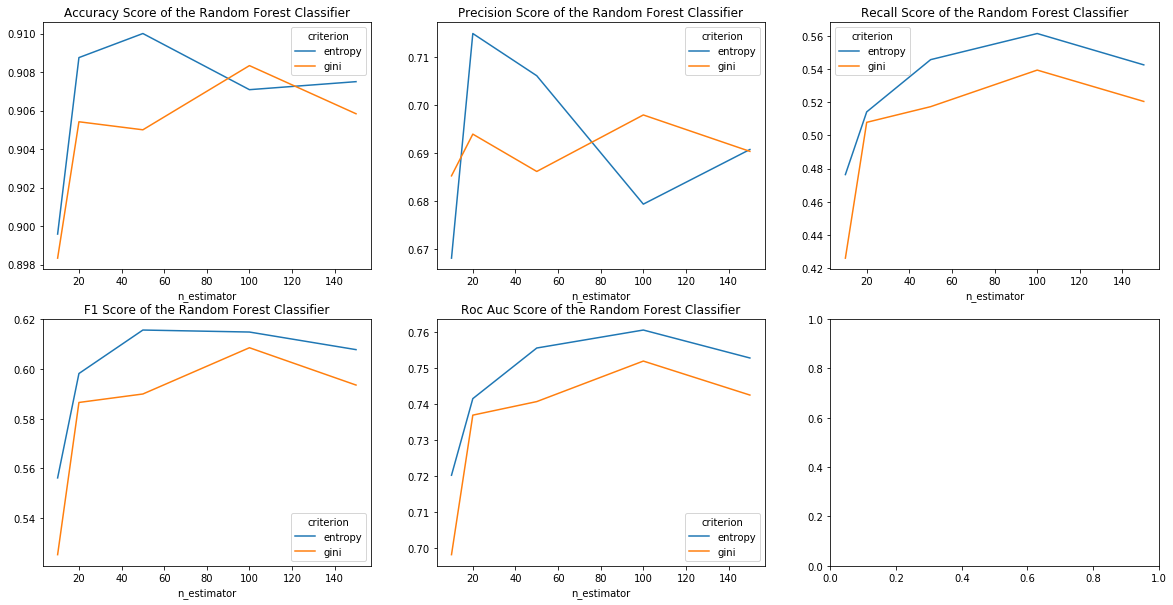

In [112]:
fig, axes=plt.subplots(2,3,figsize=(20, 10))
random_forest_score.groupby(['n_estimator', 'criterion'])['Accuracy'].mean().unstack().plot(title="Accuracy Score of the Random Forest Classifier", ax=axes[0,0])
random_forest_score.groupby(['n_estimator', 'criterion'])['Precision'].mean().unstack().plot(title="Precision Score of the Random Forest Classifier", ax=axes[0,1])
random_forest_score.groupby(['n_estimator', 'criterion'])['Recall'].mean().unstack().plot(title="Recall Score of the Random Forest Classifier", ax=axes[0,2])
random_forest_score.groupby(['n_estimator', 'criterion'])['f1'].mean().unstack().plot(title="F1 Score of the Random Forest Classifier", ax=axes[1,0])
random_forest_score.groupby(['n_estimator', 'criterion'])['roc_auc'].mean().unstack().plot(title="Roc Auc Score of the Random Forest Classifier", ax=axes[1,1])


# Try hyperparameter tuning:

# Use Randomized Search:

In [160]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 800, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10, 15, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Gini works better based on the comparison above:
criterion=['gini']


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               #'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion':criterion
                }

pprint(random_grid)

{'bootstrap': [True, False],
 'criterion': ['gini'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_leaf': [1, 2, 4, 10, 15, 20],
 'min_samples_split': [2, 5, 10, 15, 20],
 'n_estimators': [150,
                  163,
                  176,
                  189,
                  203,
                  216,
                  229,
                  242,
                  256,
                  269,
                  282,
                  295,
                  309,
                  322,
                  335,
                  348,
                  362,
                  375,
                  388,
                  402,
                  415,
                  428,
                  441,
                  455,
                  468,
                  481,
                  494,
                  508,
                  521,
                  534,
                  547,
                  561,
                  574,
                  587,
           

In [161]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 10, scoring="neg_log_loss", 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


In [162]:
print(rf_random.best_params_)
best_random = rf_random.best_estimator_


{'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}


In [163]:
best_random.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [164]:
def model_evaluation(model, test_features, test_label):
    y_pred_class=model.predict(test_features)
    
    from sklearn import metrics
    accuracy_score=metrics.accuracy_score(test_label, y_pred_class)
    precision_score=metrics.precision_score(test_label, y_pred_class)
    recall_score=metrics.recall_score(test_label, y_pred_class)
    roc_auc_score=metrics.roc_auc_score(test_label, y_pred_class)
    
    print("Model Performance:")
    
    print("accuracy score: ", accuracy_score)
    print("precision score: ", precision_score)
    print("recall score: ", recall_score)
    print("roc auc score:", roc_auc_score)

In [165]:
model_evaluation(best_random, X_test, y_test)

Model Performance:
accuracy score:  0.9045833333333333
precision score:  0.688034188034188
recall score:  0.5078864353312302
roc auc score: 0.7364204140170314


# Gird Search:

Use gird search to refine the hyperparameters:

In [166]:
{'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}

{'n_estimators': 150,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': None,
 'criterion': 'gini',
 'bootstrap': True}

In [167]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [ True],
     'max_depth': [None],
     'min_samples_leaf': [2],
     'min_samples_split': [10],
     'n_estimators': [150, 155, 160],
     'criterion':['gini']
}

# Create a base model
rf = RandomForestClassifier(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='neg_log_loss', 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

# Fit the grid search to the data
grid_search.fit(X_train, y_train);



best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    5.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    7.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [168]:
print(grid_search.best_params_)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 160}


In [169]:
model_evaluation(best_grid, X_test, y_test)

Model Performance:
accuracy score:  0.90375
precision score:  0.6822033898305084
recall score:  0.5078864353312302
roc auc score: 0.7359403372047414


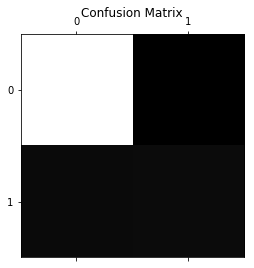

In [170]:
y_pred_class_rf=best_grid.predict(X_test)
conf_mx=confusion_matrix(y_test, y_pred_class_rf)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.title("Confusion Matrix")
plt.show()

# As you can see the accuracy score is good because we have inbalanced data. The majoity of the users are not adopted users. By looking at the precision, recall and confusion matrix, the model is not performing well in identifying the adopted users. The recall score is only 50%.

# To resolve the inbalanced data issue, I'm going to reasample the data.

# 1. Up-sample Minority Class: 

In [305]:
from sklearn.utils import resample

In [306]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=13)

In [307]:
training_set=pd.merge(X_train,pd.DataFrame(y_train), left_index=True, right_index=True )

In [308]:
# Separate majority and minority classes
df_majority=training_set.loc[training_set['User_adoption_flag']==0]
df_minority=training_set.loc[training_set['User_adoption_flag']==1]

In [309]:
print(df_majority.shape)
print(df_minority.shape)

(8447, 67)
(1153, 67)


In [310]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=8447,    # to match majority class
                                 random_state=234) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled]) 

In [311]:
df_upsampled.User_adoption_flag.value_counts()

1.0    8447
0.0    8447
Name: User_adoption_flag, dtype: int64

In [316]:
X_train=df_upsampled[df_upsampled.columns[:-1]]
y_train=df_upsampled['User_adoption_flag'].astype(int)

In [317]:
print(X_train.shape)
print(y_train.shape)

(16894, 66)
(16894,)


In [321]:
%time
random_forest_score_upsampling=[]
n_estimators_list=[10, 20, 50, 100, 150]
for n_estimator in n_estimators_list:
    for criterion in ['gini', 'entropy']:
        start_time=time.time()
        model_random_forest_clf=RandomForestClassifier(n_estimators=n_estimator,criterion=criterion, n_jobs=-1).fit(X_train,y_train)
        end_time=time.time()
        runing_time=end_time-start_time
        y_pred_class=model_random_forest_clf.predict(X_test)
        Accuracy_score=metrics.accuracy_score(y_test, y_pred_class)
        Precision_score=metrics.precision_score(y_test, y_pred_class)
        Recall_score=metrics.recall_score(y_test, y_pred_class)
        f1_score=metrics.f1_score(y_test, y_pred_class)
        roc_auc_score = metrics.roc_auc_score(y_test, y_pred_class)
        
        random_forest_score_upsampling.append(dict(n_estimator=n_estimator, criterion=criterion,  Accuracy=Accuracy_score, Precision=Precision_score, Recall=Recall_score, f1= f1_score,roc_auc=roc_auc_score, runing_time=runing_time ))
        
random_forest_score_upsampling=pd.DataFrame(random_forest_score_upsampling)


Wall time: 0 ns


In [322]:
random_forest_score_upsampling

,Accuracy,Precision,Recall,criterion,f1,n_estimator,roc_auc,runing_time
0,0.904167,0.591398,0.587189,gini,0.589286,10,0.766695,0.137391
1,0.899583,0.573529,0.555160,entropy,0.564195,10,0.750209,0.122512
2,0.908750,0.606897,0.626335,gini,0.616462,20,0.786268,0.232299
3,0.909167,0.609756,0.622776,entropy,0.616197,20,0.784960,0.252246
4,0.905000,0.587459,0.633452,gini,0.609589,50,0.787231,0.597460
5,0.903750,0.582781,0.626335,entropy,0.603774,50,0.783436,0.443171
6,0.906250,0.588050,0.665480,gini,0.624374,100,0.801829,0.799525
7,0.906667,0.592233,0.651246,entropy,0.620339,100,0.795892,0.905673
8,0.908333,0.596825,0.669039,gini,0.630872,150,0.804553,1.212439
9,0.910417,0.605096,0.676157,entropy,0.638655,150,0.808819,1.207741


By comparing on the performance, 150 estimators and entropy work the best.

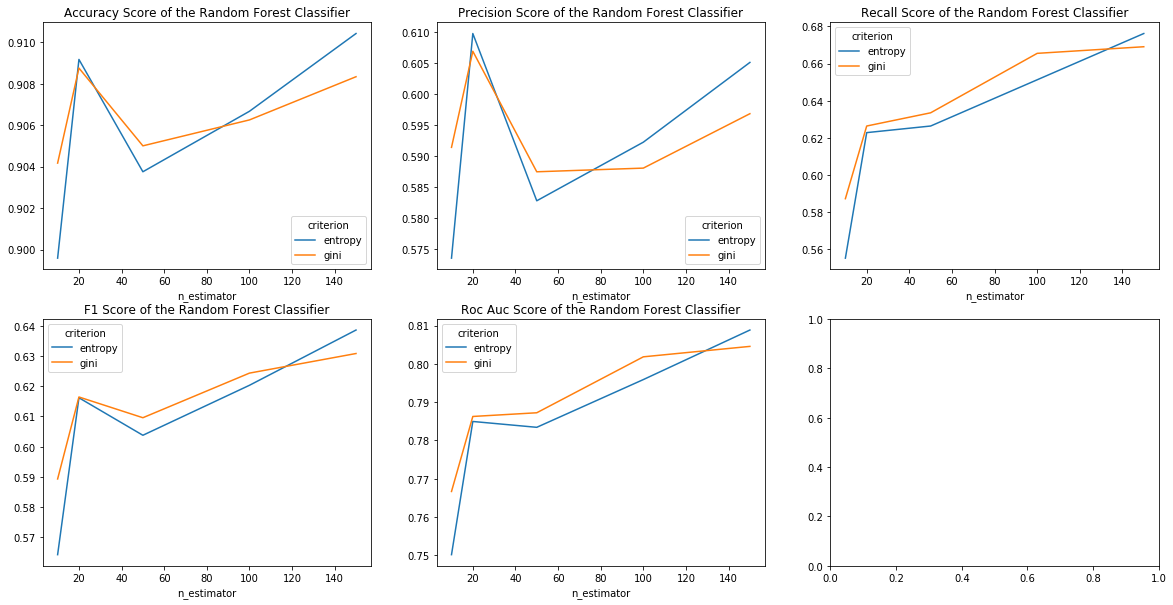

In [323]:
fig, axes=plt.subplots(2,3,figsize=(20, 10))
random_forest_score_upsampling.groupby(['n_estimator', 'criterion'])['Accuracy'].mean().unstack().plot(title="Accuracy Score of the Random Forest Classifier", ax=axes[0,0])
random_forest_score_upsampling.groupby(['n_estimator', 'criterion'])['Precision'].mean().unstack().plot(title="Precision Score of the Random Forest Classifier", ax=axes[0,1])
random_forest_score_upsampling.groupby(['n_estimator', 'criterion'])['Recall'].mean().unstack().plot(title="Recall Score of the Random Forest Classifier", ax=axes[0,2])
random_forest_score_upsampling.groupby(['n_estimator', 'criterion'])['f1'].mean().unstack().plot(title="F1 Score of the Random Forest Classifier", ax=axes[1,0])
random_forest_score_upsampling.groupby(['n_estimator', 'criterion'])['roc_auc'].mean().unstack().plot(title="Roc Auc Score of the Random Forest Classifier", ax=axes[1,1])


# The model result looks better than the original model.

# Create a function to oversample the data: 

majority_class_minority_class_ratio here is the ratio of sample size of majority class to the sample size of the minority class.

In [332]:
def func_oversample_data(majority_class_minority_class_ratio, dataset):
    
    y=dataset['User_adoption_flag']
    feature_list=[ i for i in dataset.columns if i != 'User_adoption_flag']
    X=dataset[feature_list]
    
    X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=13)
    training_set=pd.merge(X_train,pd.DataFrame(y_train), left_index=True, right_index=True )
    
    df_majority=training_set.loc[training_set['User_adoption_flag']==0]
    df_minority=training_set.loc[training_set['User_adoption_flag']==1]
    
    over_sample_size = int(df_majority.shape[0]/majority_class_minority_class_ratio)
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=over_sample_size,    # to match majority class
                                     random_state=234) # reproducible results
    
        
    print("Majority class data frame: ", df_majority.shape)
    print("Minority class data frame after upsampling: ", df_minority_upsampled.shape)
    
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled]) 

    X_train=df_upsampled[feature_list]
    y_train=df_upsampled['User_adoption_flag'].astype(int)
    
    #X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=123)
    
    %time
    random_forest_score_upsampling=[]
    n_estimators_list=[10, 20, 50, 100, 150]
    for n_estimator in n_estimators_list:
        for criterion in ['gini', 'entropy']:
            start_time=time.time()
            model_random_forest_clf=RandomForestClassifier( max_features='sqrt', min_samples_split=10, min_samples_leaf=10, n_estimators=n_estimator,criterion=criterion, n_jobs=-1).fit(X_train,y_train)
            end_time=time.time()
            runing_time=end_time-start_time
            y_pred_class=model_random_forest_clf.predict(X_test)
            Accuracy_score=metrics.accuracy_score(y_test, y_pred_class)
            Precision_score=metrics.precision_score(y_test, y_pred_class)
            Recall_score=metrics.recall_score(y_test, y_pred_class)
            f1_score=metrics.f1_score(y_test, y_pred_class)
            roc_auc_score = metrics.roc_auc_score(y_test, y_pred_class)

            random_forest_score_upsampling.append(dict(n_estimator=n_estimator, criterion=criterion,  Accuracy=Accuracy_score, Precision=Precision_score, Recall=Recall_score, f1= f1_score,roc_auc=roc_auc_score, runing_time=runing_time ))

    random_forest_score_upsampling=pd.DataFrame(random_forest_score_upsampling)
    
    display(random_forest_score_upsampling)
    
    
    fig, axes=plt.subplots(2,3,figsize=(20, 10))
    random_forest_score_upsampling.groupby(['n_estimator', 'criterion'])['Accuracy'].mean().unstack().plot(title="Accuracy Score of the Random Forest Classifier", ax=axes[0,0])
    random_forest_score_upsampling.groupby(['n_estimator', 'criterion'])['Precision'].mean().unstack().plot(title="Precision Score of the Random Forest Classifier", ax=axes[0,1])
    random_forest_score_upsampling.groupby(['n_estimator', 'criterion'])['Recall'].mean().unstack().plot(title="Recall Score of the Random Forest Classifier", ax=axes[0,2])
    random_forest_score_upsampling.groupby(['n_estimator', 'criterion'])['f1'].mean().unstack().plot(title="F1 Score of the Random Forest Classifier", ax=axes[1,0])
    random_forest_score_upsampling.groupby(['n_estimator', 'criterion'])['roc_auc'].mean().unstack().plot(title="Roc Auc Score of the Random Forest Classifier", ax=axes[1,1])
    
    return X_train, y_train, X_test, y_test

    
    
    

# To avoid overfitting, I have made the following adjustment on the model:
- Adjust max_features to "sqrt" 
- ajust min_samples_split to 10 
- Adjust min_samples_leaf to 10
- Adjust the ratio of majority class sample to minority class sample to 2 instead of 1.


Majority class data frame:  (8447, 67)
Minority class data frame after upsampling:  (4223, 67)
Wall time: 498 µs


,Accuracy,Precision,Recall,criterion,f1,n_estimator,roc_auc,runing_time
0,0.906250,0.570352,0.807829,gini,0.668630,10,0.863565,0.114078
1,0.911667,0.592000,0.790036,entropy,0.676829,10,0.858916,0.110111
2,0.907917,0.577720,0.793594,gini,0.668666,20,0.858336,0.221331
3,0.910833,0.587927,0.797153,entropy,0.676737,20,0.861531,0.125593
4,0.912083,0.592593,0.797153,gini,0.679818,50,0.862239,0.375857
5,0.909167,0.583113,0.786477,entropy,0.669697,50,0.855957,0.372541
6,0.911250,0.587629,0.811388,gini,0.681614,100,0.867940,0.495076
7,0.909583,0.582902,0.800712,entropy,0.674663,100,0.862366,0.488314
8,0.910417,0.585938,0.800712,gini,0.676692,150,0.862838,0.691614
9,0.912083,0.591146,0.807829,entropy,0.682707,150,0.866869,0.683373


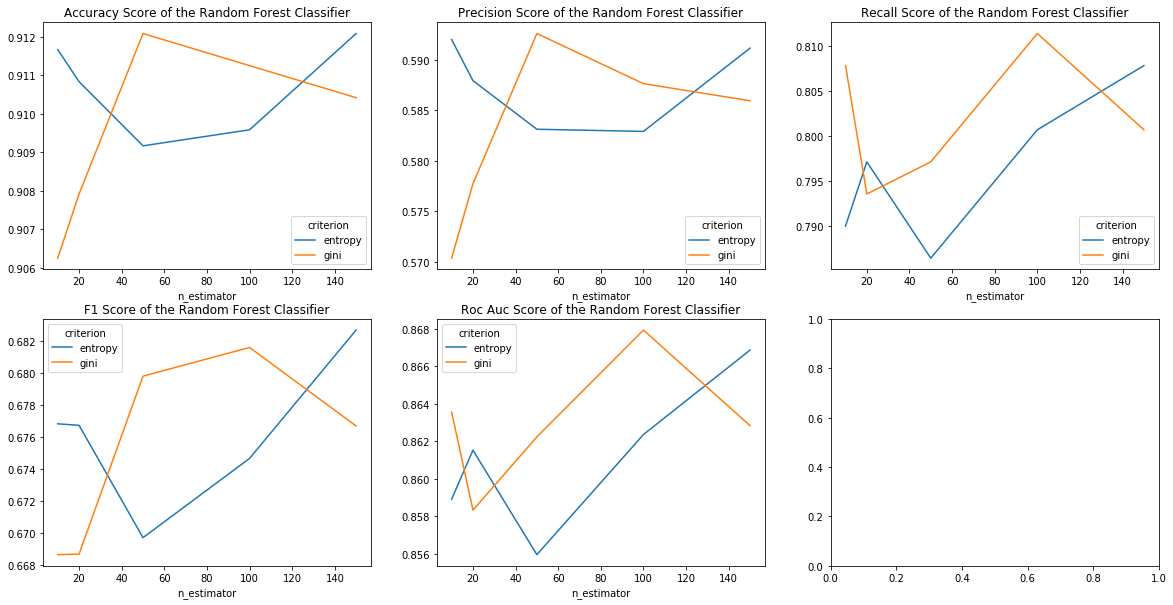

In [333]:
dataset=user_data_copy_update4
majority_class_minority_class_ratio=2
X_train, y_train, X_test, y_test=func_oversample_data(majority_class_minority_class_ratio, dataset)

# Here I'm going to use majority_class_minority_class_ratio=2, criterion='entropy',  n_estimators=150.

In [334]:
model_random_forest_clf_best_estimator=RandomForestClassifier( max_features='sqrt', min_samples_split=10, min_samples_leaf=10, n_estimators=150,criterion='entropy', n_jobs=-1).fit(X_train,y_train)

# Below is the performance on the testing set.

In [335]:
model_evaluation(model_random_forest_clf_best_estimator, X_test, y_test)

Model Performance:
accuracy score:  0.9095833333333333
precision score:  0.5833333333333334
recall score:  0.797153024911032
roc auc score: 0.8608228550699568


# Get the important features from the random forest classifier.

In [336]:
model_random_forest_clf_best_estimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# By looking at the feature importance, you will find the total user sessions for the first 30 days, the average weekly sessions for the first 30 days are the most importance features.

<Figure size 720x432 with 0 Axes>

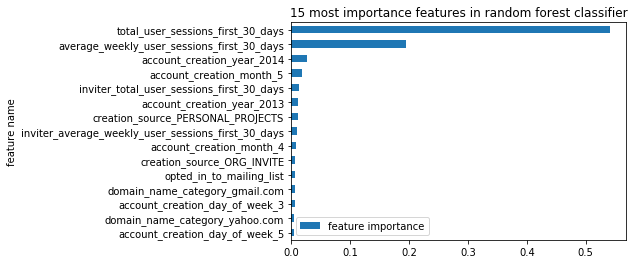

In [337]:
plt.figure(figsize=(10, 6))
feature_list1=list(X_train.columns)
model_random_forest_feature_importance_df=pd.DataFrame(list(zip(feature_list1, model_random_forest_clf_best_estimator.feature_importances_)), columns=['feature name', 'feature importance'])
model_random_forest_feature_importance_df=model_random_forest_feature_importance_df.sort_values(by='feature importance', ascending=False)
model_random_forest_feature_importance_df.set_index('feature name', inplace=True)
model_random_forest_feature_importance_df[:15]. sort_values(by='feature importance', ascending=True).plot(kind='barh', title="15 most importance features in random forest classifier")
plt.show()


# Another way to deal with inbalanced problem:
# Use Penalize Algorithms (Cost-Sensitive Training)

During training, we can use the argument class_weight='balanced'  to penalize mistakes on the minority class by an amount proportional to how under-represented it is.

We also want to include the argument probability=True  if we want to enable probability estimates for SVM algorithms.

So below I'm training a model using Penalized_SVM on the original imbalanced dataset.


In [185]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

# for running svm model, I need to scale the following numeric values in the dataset:
- average_weekly_user_sessions_first_30_days
- total_user_sessions_first_30_days
- inviter_average_weekly_user_sessions_first_30_days
- inviter_total_user_sessions_first_30_days

In [200]:
scaler=MinMaxScaler()
df_scaled=pd.DataFrame(scaler.fit_transform(user_data_copy_update4[['average_weekly_user_sessions_first_30_days',
'total_user_sessions_first_30_days',
'inviter_average_weekly_user_sessions_first_30_days',
'inviter_total_user_sessions_first_30_days' ]]), columns=['average_weekly_user_sessions_first_30_days',
'total_user_sessions_first_30_days',
'inviter_average_weekly_user_sessions_first_30_days',
'inviter_total_user_sessions_first_30_days' ])

In [203]:
df_scaled.columns=df_scaled.columns+'_scaled'

In [208]:
user_data_copy_update5=user_data_copy_update4.copy()

In [210]:
user_data_copy_update5.reset_index(inplace=True)

In [211]:
for column in ['average_weekly_user_sessions_first_30_days',
'total_user_sessions_first_30_days',
'inviter_average_weekly_user_sessions_first_30_days',
'inviter_total_user_sessions_first_30_days' ]: 
    
    del user_data_copy_update5[column]

In [215]:
user_data_copy_update5=pd.merge(user_data_copy_update5, df_scaled, left_index=True, right_index=True)

In [217]:
user_data_copy_update5.set_index('object_id', inplace=True)

In [222]:
y=user_data_copy_update5[user_data_copy_update5.columns[0]]
X=user_data_copy_update5[user_data_copy_update5.columns[1:]]

In [228]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=113)

In [229]:

clf_svc = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)

clf_svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# Below is the model performance on the testing set:

As you can see after penalizing the training on the majority class, the recall score has improved a lot compared with the original model. But the model is not as precise as before.

In [232]:
model_evaluation(clf_svc, X_test, y_test)

Model Performance:
accuracy score:  0.9004166666666666
precision score:  0.5668316831683168
recall score:  0.7815699658703071
roc auc score: 0.8492567437324957


In [340]:
svc_coefficient_model=pd.DataFrame({'Feature Name': list(X_train.columns), 'Coefficient': list(clf_svc.coef_[0] )})

In [341]:
svc_coefficient_model.set_index('Feature Name', inplace=True)

In [342]:
svc_coefficient_model.sort_values(by='Coefficient', ascending=False, inplace=True)

Below are the top 15 features that are positively impacting the classification. As you can see, total user sessions for the first 30 days and the average weekly sessions for the first 30 days are the most important positive features.

<Figure size 1080x720 with 0 Axes>

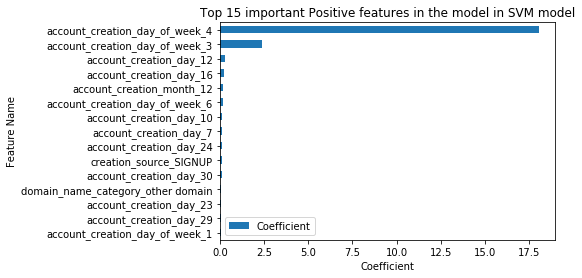

In [343]:
plt.figure(figsize=(15, 10))
svc_coefficient_model.iloc[:15, :].sort_values(by='Coefficient', ascending=True).plot(kind='barh')
plt.xlabel('Coefficient')
plt.title("Top 15 important Positive features in the model in SVM model")
plt.show()

Below are the top 15 negative features for the classification model. The timing of the account creation has become the most important negative factors. For example, people who signed up in 2014 are less likely to be adopted. 
Also organization invite has become a negative factor which means people who get invited by their organization are actually less likely to be adopted.

<Figure size 1080x720 with 0 Axes>

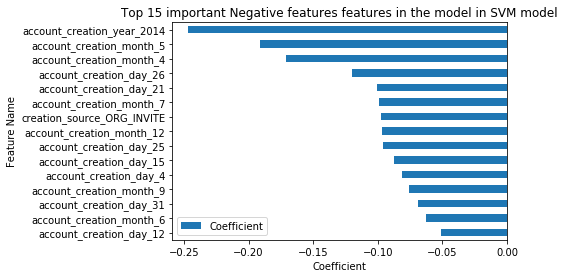

In [338]:
svc_coefficient_model.sort_values(by='Coefficient', ascending=True, inplace=True)
plt.figure(figsize=(15, 10))
svc_coefficient_model.iloc[:15, :].sort_values(by='Coefficient', ascending=False).plot(kind='barh')
plt.xlabel('Coefficient')
plt.title("Top 15 important Negative features features in the model in SVM model")
plt.show()

Reference: How to solve imbalanced data in the model
- https://elitedatascience.com/imbalanced-classes
- https://towardsdatascience.com/dealing-with-imbalanced-classes-in-machine-learning-d43d6fa19d2
- https://towardsdatascience.com/working-with-highly-imbalanced-datasets-in-machine-learning-projects-c70c5f2a7b16
- https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18